In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
import os

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
root_dir = "/content/drive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

In [0]:
# os.mkdir('/content/drive/My Drive/fastai-v3/data/car scratch segmentation')

In [0]:
path_models = Path('/content/drive/My Drive/fastai-v3/data/car scratch segmentation/models')

In [0]:
# path_models.mkdir()

In [0]:
fnames = get_image_files(path/'train')
fnames[:3]

[PosixPath('/content/Data/train/image46.png'),
 PosixPath('/content/Data/train/image19.jpg'),
 PosixPath('/content/Data/train/image17.jpg')]

In [0]:
lbl_names= get_image_files(path/'masks')
lbl_names[:3]

[PosixPath('/content/Data/masks/image23_mask.png'),
 PosixPath('/content/Data/masks/image10_mask.png'),
 PosixPath('/content/Data/masks/image38_mask.png')]

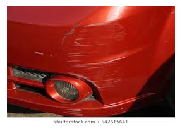

In [0]:
img_f = fnames[1]
img = open_image(img_f)
img.show(fig_size=(10,10))

In [0]:
def get_y_fn(x): return Path(str(x.parent.parent) +'/masks')/ (x.stem+"_mask.png")
codes = array(['nonscratch','scratch'])

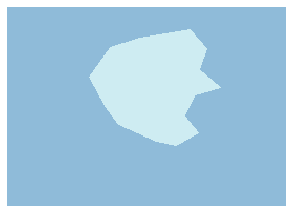

In [0]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=0.5)

In [0]:
mask.data.shape

torch.Size([1, 190, 266])

In [0]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([190, 266]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [0]:
type(mask.data)

torch.Tensor

In [0]:
!unzip -q '/content/drive/My Drive/Archive2.zip' -d '/content/Archive2'

In [0]:
cars_path= Path('/content/Archive2')

In [0]:
np.random.seed(40)
data = (ImageList.from_folder(cars_path).
        split_by_folder(train = 'training', valid = 'validation').
        label_from_folder().
        transform(get_transforms(),size = 224).
        databunch(bs = 256).
        normalize(imagenet_stats))

In [0]:
bs=4
src = (SegmentationItemList.from_folder(path/'train').
       split_by_rand_pct(0.2).
       label_from_func(get_y_fn, classes = codes))

In [0]:
data = (src.transform(get_transforms(), tfm_y = True, size = (224,224)).
        databunch(bs = bs).
        normalize(imagenet_stats))

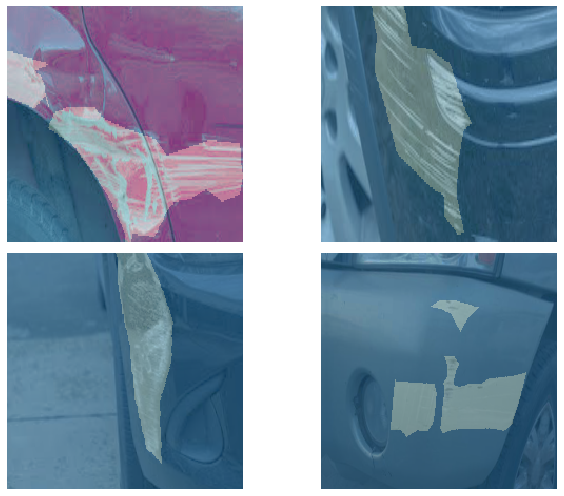

In [0]:
data.show_batch(6, figsize = (10, 7))

In [0]:
def acc_cars(input, target):
  target = target.squeeze(1)
  return (input.argmax(dim=1)==target).float().mean()

In [0]:
# metrics = acc_camvid
wd = 1e-2

In [0]:
model = models.resnet34(pretrained=True)

In [0]:
__all__ = ['cnn_learner', 'create_cnn', 'create_cnn_model', 'create_body', 'create_head', 'unet_learner']
# By default split models between first and second layer
def _default_split(m:nn.Module): return (m[1],)
# Split a resnet style model
def _resnet_split(m:nn.Module): return (m[0][6],m[1])
# Split squeezenet model on maxpool layers
def _squeezenet_split(m:nn.Module): return (m[0][0][5], m[0][0][8], m[1])
def _densenet_split(m:nn.Module): return (m[0][0][7],m[1])
def _vgg_split(m:nn.Module): return (m[0][0][22],m[1])
def _alexnet_split(m:nn.Module): return (m[0][0][6],m[1])
def _mobilenetv2_split(m:nn.Module): return (m[0][0][10],m[1])

In [0]:
_default_meta     = {'cut':None, 'split':_default_split}
_resnet_meta      = {'cut':-2, 'split':_resnet_split }
_squeezenet_meta  = {'cut':-1, 'split': _squeezenet_split}
_densenet_meta    = {'cut':-1, 'split':_densenet_split}
_vgg_meta         = {'cut':-1, 'split':_vgg_split}
_alexnet_meta     = {'cut':-1, 'split':_alexnet_split}
_mobilenetv2_meta = {'cut':-1, 'split':_mobilenetv2_split}

In [0]:
model_meta = {
    models.resnet18 :{**_resnet_meta}, models.resnet34: {**_resnet_meta},
    models.resnet50 :{**_resnet_meta}, models.resnet101:{**_resnet_meta},
    models.resnet152:{**_resnet_meta},

    models.squeezenet1_0:{**_squeezenet_meta},
    models.squeezenet1_1:{**_squeezenet_meta},

    models.densenet121:{**_densenet_meta}, models.densenet169:{**_densenet_meta},
    models.densenet201:{**_densenet_meta}, models.densenet161:{**_densenet_meta},
    models.vgg11_bn:{**_vgg_meta}, models.vgg13_bn:{**_vgg_meta}, models.vgg16_bn:{**_vgg_meta}, models.vgg19_bn:{**_vgg_meta},
    models.alexnet:{**_alexnet_meta},
    # models.mobilenet_v2:{**_mobilenetv2_meta}
    }

In [0]:
def cnn_config(arch):
    "Get the metadata associated with `arch`."
    torch.backends.cudnn.benchmark = True
    return model_meta.get(arch, _default_meta)

In [0]:
body = custom_create_body(models.resnet34)
# body.load_state_dict(torch.load('/content/drive/My Drive/fastai-v3/data/car classification/models/carsdict.pth'))

In [0]:
def custom_create_body(arch:Callable, pretrained:bool=True, cut:Optional[Union[int, Callable]]=None):
    "Cut off the body of a typically pretrained `model` at `cut` (int) or cut the model as specified by `cut(model)` (function)."
    model = torch.load('/content/drive/My Drive/fastai-v3/data/car classification/models/carsclassifier.pth')
    cut = ifnone(cut, cnn_config(arch)['cut'])
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if   isinstance(cut, int):      return nn.Sequential(*list(model.children())[:cut])
    elif isinstance(cut, Callable): return cut(model)
    else:                           raise NamedError("cut must be either integer or a function")

In [0]:
def custom_unet_learner(data:DataBunch, arch:Callable, pretrained:bool=True, blur_final:bool=True,
                 norm_type:Optional[NormType]=NormType, split_on:Optional[SplitFuncOrIdxList]=None, blur:bool=False,
                 self_attention:bool=False, y_range:Optional[Tuple[float,float]]=None, last_cross:bool=True,
                 bottle:bool=False, cut:Union[int,Callable]=None, **learn_kwargs:Any)->Learner:
    "Build Unet learner from `data` and `arch`."
    meta = cnn_config(arch)
    body = custom_create_body(arch, pretrained, cut)
    try:    size = data.train_ds[0][0].size
    except: size = next(iter(data.train_dl))[0].shape[-2:]
    model = to_device(models.unet.DynamicUnet(body, n_classes=data.c, img_size=size, blur=blur, blur_final=blur_final,
          self_attention=self_attention, y_range=y_range, norm_type=norm_type, last_cross=last_cross,
          bottle=bottle), data.device)
    learn = Learner(data, model, **learn_kwargs)
    learn.split(ifnone(split_on, meta['split']))
    if pretrained: learn.freeze()
    apply_init(model[2], nn.init.kaiming_normal_)
    return learn

In [0]:
learn = custom_unet_learner(data, models.resnet34, metrics = acc_cars, wd = wd, bottle = True )

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.51E-05
Min loss divided by 10: 7.59E-04


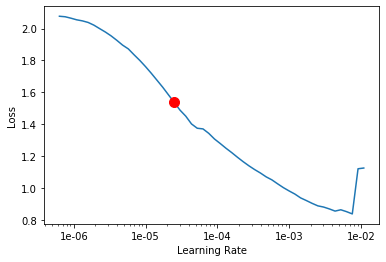

In [0]:
learn.freeze()
lr_find(learn)
learn.recorder.plot(suggestion=True)

In [0]:
lr = 2e-5
learn.freeze()
learn.fit_one_cycle(5, slice(lr), pct_start = 0.8)

epoch,train_loss,valid_loss,acc_cars,time
0,0.166239,0.211007,0.925296,00:02
1,0.164913,0.205309,0.928066,00:02
2,0.162226,0.198481,0.931100,00:02
3,0.166809,0.257375,0.915254,00:02
4,0.170138,0.265737,0.913369,00:02


In [0]:
# learn.save(path_models/'stage1-frozen-224')
learn.load(path_models/'stage1-frozen-224')

In [0]:
lr = 2e-5
learn.fit_one_cycle(5, slice(lr), pct_start = 0.8)

epoch,train_loss,valid_loss,acc_cars,time
0,0.388214,0.396806,0.875381,00:02
1,0.376307,0.396792,0.881619,00:01
2,0.368576,0.341378,0.885361,00:02
3,0.349095,0.291709,0.896407,00:01
4,0.318843,0.225830,0.908728,00:01


In [0]:
# learn.save(path_models/'stage2-frozen-224')
learn.load(path_models/'stage2-frozen-224')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-03
Min loss divided by 10: 1.45E-06


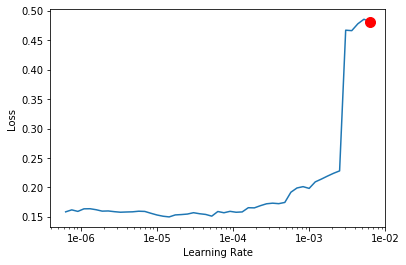

In [0]:
learn.unfreeze()
lr_find(learn)
learn.recorder.plot(suggestion = True)

In [0]:
learn.fit_one_cycle(10, slice(1e-5, 1e-4), pct_start = 0.8)

epoch,train_loss,valid_loss,acc_cars,time
0,0.110839,0.205295,0.935217,00:02
1,0.110373,0.178566,0.936758,00:02
2,0.109899,0.206950,0.932564,00:02
3,0.104725,0.209924,0.934094,00:02
4,0.103211,0.173229,0.936811,00:02
5,0.098869,0.275766,0.929922,00:02
6,0.099815,0.177119,0.941340,00:02
7,0.102811,0.235892,0.925817,00:02
8,0.104784,0.201737,0.913604,00:02
9,0.102510,0.196700,0.939936,00:02


In [0]:
# learn.save(path_models/'stage1-unfrozen-224')
learn.load(path_models/'stage1-unfrozen-224')

In [0]:
learn.fit_one_cycle(10, slice(1e-5, 1e-4), pct_start = 0.8)

epoch,train_loss,valid_loss,acc_cars,time
0,0.139050,0.169737,0.929865,00:02
1,0.142742,0.143928,0.938740,00:02
2,0.132999,0.133243,0.944179,00:02
3,0.127841,0.206738,0.932256,00:02
4,0.123249,0.154172,0.942768,00:02
5,0.125402,0.141439,0.937305,00:02
6,0.125843,0.134825,0.944398,00:02
7,0.123275,0.253873,0.921441,00:02
8,0.120133,0.143647,0.942677,00:02
9,0.117342,0.109041,0.951170,00:02


In [0]:
learn.save(path_models/'stage2-unfrozen-224')
# learn.load(path_models/'stage2-unfrozen-224')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 6.92E-07


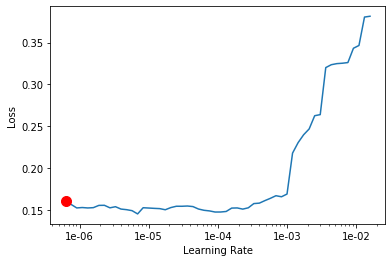

In [0]:
# training with extra lighting
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [0]:
learn.fit_one_cycle(10, slice(1e-6,1e-5, 1e-4), pct_start = 0.8)

epoch,train_loss,valid_loss,acc_cars,time
0,0.151054,0.133314,0.950658,00:02
1,0.150724,0.128190,0.948729,00:02
2,0.145743,0.120614,0.954228,00:02
3,0.142207,0.110807,0.956504,00:02
4,0.141611,0.110317,0.955875,00:02
5,0.139418,0.106177,0.956595,00:02
6,0.136509,0.105490,0.956427,00:02
7,0.131697,0.111721,0.953322,00:02
8,0.128264,0.107237,0.954053,00:02
9,0.126702,0.112367,0.954022,00:02


In [0]:
learn.save(path_models/'stage2-unfrozen-light-224')
# learn.load(path_models/'stage2-unfrozen-light-224')

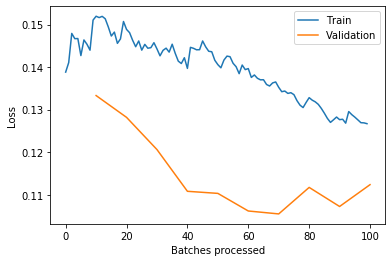

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.save(path_models/'experimentmodel')
# learn.load(path_models/'experimentmodel')

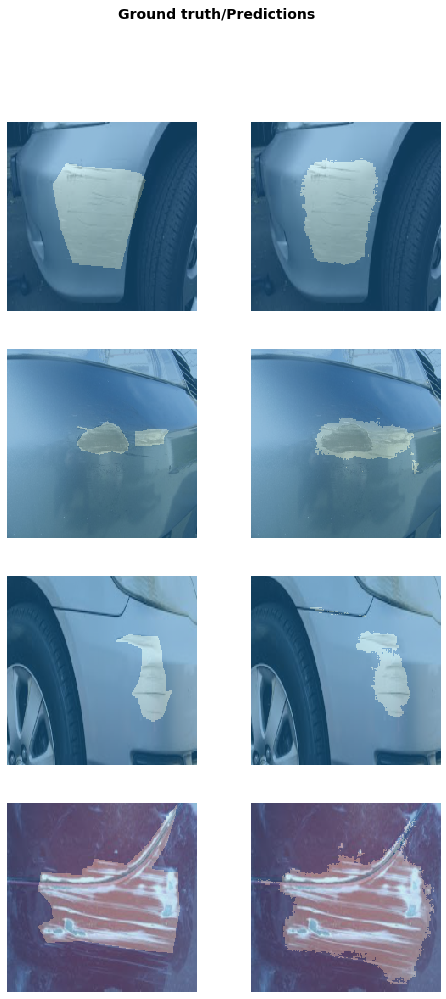

In [0]:
learn.show_results()

In [0]:
img = open_image('/content/Data/train/image16.jpg')
# type(img)
# img

In [0]:
# %%time
def model_input(img):
    mask,_,_ = learn.predict(img)
    alpha = 0.3
    out = alpha * mask.data + (1-alpha) * img.resize(224).data
    out = np.array(out)
    out = np.transpose(out, (1,2,0))
    return out

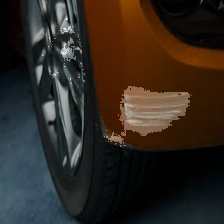

In [0]:
img = open_image('/content/Data/train/image16.jpg')
out = model_input(img)

cv2_imshow(out*255)

In [0]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

In [0]:
cap = cv2.VideoCapture('/content/high res scratch.mp4')
while(cap.isOpened()):
    ret, frame = cap.read()
    rgb = np.transpose(frame/255.0, (2,0,1))
    rgb = torch.tensor(rgb).float()
    rgb = Image(rgb.cpu())
    out = model_input(rgb)
    cv2_imshow(out*255)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()